In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

from scipy.stats import lognorm

import matplotlib.dates as mdates

from astropy.io import ascii
import numpy as np
import astropy.units as u
import pandas as pd
from astropy.time import Time
from astropy.visualization import hist

from minicyclop.io import read_latest, read_seeing_data

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
d = read_latest(Path.home() / "MMT/minicyclop/data/MiniCyclop/Data/Last_Seeing_Data.txt")

In [3]:
d['obstime'] - Time.now()

<TimeDelta object: scale='tai' format='jd' value=-0.3299813386717849>

In [4]:
filename = Path.home() / "MMT/minicyclop/data/MiniCyclop/Data/Seeing_Data.txt"
dt = ascii.read(filename, delimiter='|', names=['UT', 'MST', 'JD', 'flux', 'seeing', 'r0'])

In [5]:
ut = Time(dt['JD'], scale='utc', format='jd')
ut.isot

array(['2022-06-08T03:32:32.968', '2022-06-08T03:33:27.409',
       '2022-06-08T03:34:23.655', ..., '2022-09-15T12:45:42.146',
       '2022-09-15T12:46:29.588', '2022-09-15T12:47:17.748'], dtype='<U23')

In [9]:
df = read_seeing_data(Path.home() / "MMT/minicyclop/data/MiniCyclop/Data/Seeing_Data.txt")
#bino = pd.read_csv("/mnt/f/wfsdat/20220706/reanalyze_results.csv")
#bino = bino.set_index(pd.DatetimeIndex(bino['time'], name='ut'))

In [20]:
df = df[(df.index > '2022-09-06')]

In [21]:
df['epoch_ms'][0], df.columns
df.to_csv("cyclop.csv")

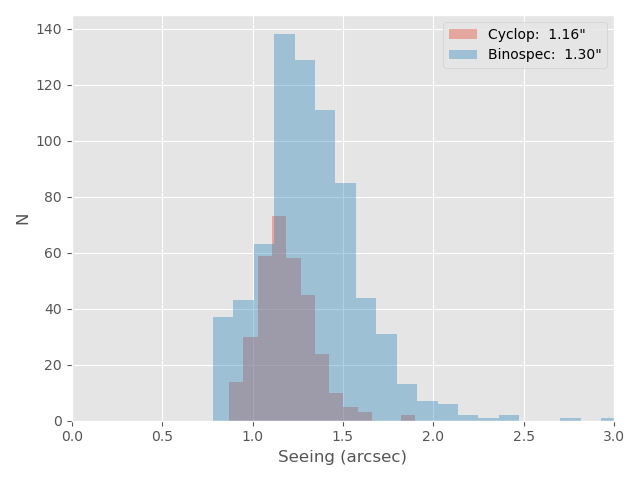

In [23]:
jul6 = df.loc['2022-07-06']
fig = plt.figure()
c_med = np.median(jul6['seeing'])
b_med = np.median(bino['seeing'])
with plt.style.context('ggplot'):
    hist(jul6['seeing'], bins='scott', histtype='stepfilled', alpha=0.4, label=f"Cyclop: {c_med: .2f}\"")
    hist(bino['seeing'], bins='scott', histtype='stepfilled', alpha=0.4, label=f"Binospec: {b_med: .2f}\"")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
    plt.xlim([0.0, 3.0])
    plt.legend()
    plt.tight_layout()
plt.savefig("cyc_bino_hist_20220706.pdf")
plt.show()

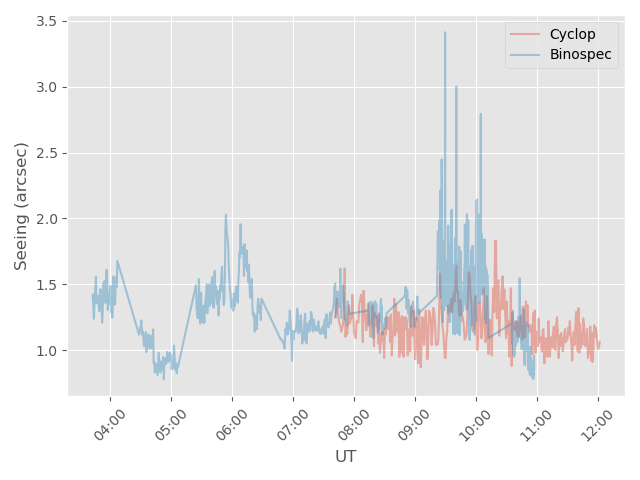

In [22]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots()
    plt.plot(jul6.index, jul6['seeing'], label="Cyclop", alpha=0.4)
    plt.plot(bino.index, bino['seeing'], label='Binospec', alpha=0.4)
    ax.tick_params(axis="x", labelrotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    plt.ylabel("Seeing (arcsec)")
    plt.xlabel("UT")
    plt.legend()
    plt.tight_layout()
plt.savefig("cyc_bino_20220706.pdf")
plt.show()

In [52]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(df['seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(df['seeing'])
fit_median = exp_mu + loc

0.36861218108097543 0.3504576040815534 0.6942742251606533


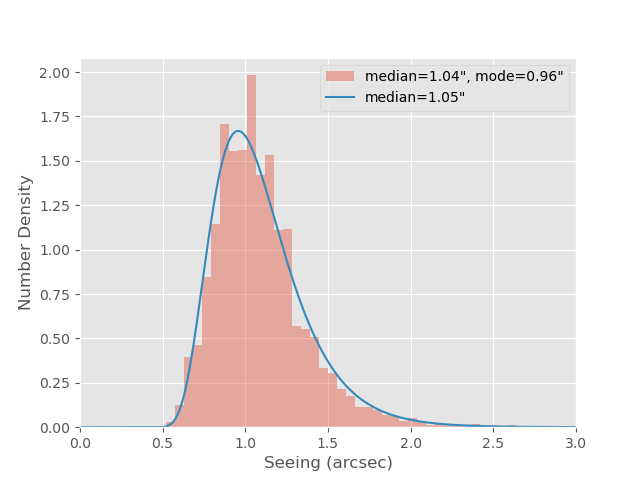

In [53]:
fig = plt.figure()
with plt.style.context('ggplot'):
    hist(df['seeing'], bins='scott', histtype='stepfilled', alpha=0.4, density=True)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.xlim([0.0, 3.0])
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
plt.show()